# Projeto Integrador I - EDA

A imobiliária Properati publica periodicamente informações sobre ofertas de imóveis para venda e aluguel. Deve aconselhar o agente imobiliário a desenvolver um modelo de regressão que permita prever o preço por metro quadrado de um imóvel. O objetivo final é que o modelo desenvolvido por eles seja utilizado como avaliador automático a ser aplicado nos próximos imóveis que forem comercializados pela empresa. Para isso, a empresa disponibiliza um conjunto de dados correspondente ao primeiro semestre de 2017.


**Objetivos:**


*   Executar uma limpeza do conjunto de dados fornecido. Em particular, você precisará elaborar estratégias para lidar com dados ausentes em determinadas variáveis.
*   Realizar uma análise descritiva das principais variáveis.
*   Criar novas colunas de determinados recursos que podem ter valor preditivo.


## Importando a Base de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
import shapely.wkt
import pyproj
from shapely.geometry import Point

In [2]:
prop = pd.read_csv(r"C:\Users\RedRagon\Documents\ProjetoIntegrador1\Data\Real_State_Properati.csv",sep='\t')


## Entendo as informações que possuímos na base



### Visualizando a base

In [3]:
prop.shape

(17223, 9)

In [4]:
prop.head(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


### Verificando se existem valores vazios ou nulos e os tipos das colunas

In [5]:
prop.isna().sum()

property_type          0
place_name             0
country_name           0
state_name             0
lat                    0
lon                    0
price                  0
currency               0
surface_total_in_m2    0
dtype: int64

In [6]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


### Verificando quantos itens distintos possuímos nas colunas

In [7]:
for col in prop.columns:
    print(col, "-", len(prop[col].unique()))

property_type - 4
place_name - 62
country_name - 1
state_name - 1
lat - 9714
lon - 9704
price - 2754
currency - 2
surface_total_in_m2 - 568


In [8]:
prop['property_type'].unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

### Verificando qual a quantidade e o peso de cada tipo de Propriedade

In [9]:
prop.groupby(by = 'property_type').count()['place_name'].sort_values(ascending = False)

property_type
apartment    14428
PH            1142
house          888
store          765
Name: place_name, dtype: int64

In [10]:
prop['property_type'].value_counts()/len(prop['property_type'])*100

apartment    83.771701
PH            6.630668
house         5.155896
store         4.441735
Name: property_type, dtype: float64

### Verificando qual a quantidade e o peso de cada tipo de Moeda


In [11]:
prop.groupby(by = 'currency').count()['place_name'].sort_values(ascending = False)

currency
USD    16700
ARS      523
Name: place_name, dtype: int64

In [12]:
prop['currency'].value_counts()/len(prop['currency'])*100

USD    96.963363
ARS     3.036637
Name: currency, dtype: float64

## Limpando os Dados

### Removendo colunas desnecessárias

Como o país e o estados são os mesmos pra todo o dataset, então podemos retirá-los pois não irá inteferir em nosso estudo.

In [13]:
prop.drop(columns=['country_name','state_name'], inplace= True)

In [14]:
prop.columns

Index(['property_type', 'place_name', 'lat', 'lon', 'price', 'currency',
       'surface_total_in_m2'],
      dtype='object')

### Normalizando o preço com base em dólares e removendo colunas desnecessárias

In [15]:
prop["price_usd"] = prop.apply(lambda x: x["price"] if x["currency"] == "USD" else x["price"]/117.41,axis=1)

Como deixamos tudo em dólar e ainda criamos outra coluna para esse preço em dólar, podemos então tirar as colunas "price" e "currency" pois não fará diferença em nossos estudos também.

In [16]:
prop.drop(columns=['price','currency'], inplace= True)

In [17]:
prop.columns

Index(['property_type', 'place_name', 'lat', 'lon', 'surface_total_in_m2',
       'price_usd'],
      dtype='object')

### Criando uma coluna com o preço por metro quadrado

In [18]:
prop["preco_metro2"] = prop.price_usd / prop.surface_total_in_m2

In [19]:
prop.columns

Index(['property_type', 'place_name', 'lat', 'lon', 'surface_total_in_m2',
       'price_usd', 'preco_metro2'],
      dtype='object')

### Verificando a distribuição dos dados para as colunas de tamanho e preço de propriedade

In [20]:
for i in prop.property_type.unique():
    print(i)
    print(prop.loc[prop.property_type == i,['preco_metro2']].describe())
    print('--------------------')

PH
       preco_metro2
count   1142.000000
mean    1695.710382
std      913.749082
min       18.370350
25%     1222.549020
50%     1625.000000
75%     2053.632764
max    25000.000000
--------------------
apartment
       preco_metro2
count  1.442800e+04
mean            inf
std             NaN
min    1.051501e+01
25%    2.018824e+03
50%    2.459016e+03
75%    3.018878e+03
max             inf
--------------------
house
       preco_metro2
count    888.000000
mean    1716.153891
std     1699.025955
min      214.592275
25%     1057.179184
50%     1451.163795
75%     1946.810507
max    23064.516129
--------------------
store
       preco_metro2
count    765.000000
mean    2794.266120
std     2139.406072
min        6.067020
25%     1454.545455
50%     2258.064516
75%     3538.461538
max    22000.000000
--------------------


#### Identificado que existe problema com a coluna preço por metro quadrado para o apartamentos

In [21]:
for i in prop.property_type.unique():
    print(i)
    print(prop.loc[prop.property_type == i, 'preco_metro2'].std())
    print('--------------------')

PH
913.7490817204806
--------------------
apartment
nan
--------------------
house
1699.0259549644643
--------------------
store
2139.406071876024
--------------------


Olhando o notebook, verificamos que contém alguns imóveis com a surface igual a 0.

In [22]:
prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)]

,property_type,place_name,lat,lon,surface_total_in_m2,price_usd,preco_metro2
2486,apartment,Palermo Soho,-34.589974,-58.425614,0.0,780000.0,inf
4872,apartment,Recoleta,-34.588818,-58.390648,0.0,320000.0,inf
5454,apartment,Caballito,-34.617348,-58.449404,0.0,68500.0,inf
6318,apartment,Palermo Hollywood,-34.582558,-58.432585,0.0,175000.0,inf
7170,apartment,Barracas,-34.641131,-58.369122,0.0,135000.0,inf
15888,apartment,Barrio Norte,-34.598727,-58.395851,0.0,112000.0,inf


#### Removendo essas linhas e verificando os novos valores de desvio padrão

In [23]:
prop.drop(index = list(prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)].index),inplace = True)

In [24]:
for i in prop.property_type.unique():
    print(prop.loc[prop.property_type == i, 'preco_metro2'].std())

913.7490817204806
2750.929484751443
1699.0259549644643
2139.406071876024


### Limpando os dados conforme a distribuição - Via Desvio Padrão

In [25]:
for i in prop.property_type.unique():
    print(i)
    print("Temos", prop.loc[(prop.property_type == i) & (prop.preco_metro2 > 3*prop.preco_metro2.std()),'preco_metro2'].shape[0], "linha(s) onde o valor supera 3 vezes o desvio padrão")
    print('-------------------------------------------------------------')

PH
Temos 1 linha(s) onde o valor supera 3 vezes o desvio padrão
-------------------------------------------------------------
apartment
Temos 211 linha(s) onde o valor supera 3 vezes o desvio padrão
-------------------------------------------------------------
house
Temos 7 linha(s) onde o valor supera 3 vezes o desvio padrão
-------------------------------------------------------------
store
Temos 20 linha(s) onde o valor supera 3 vezes o desvio padrão
-------------------------------------------------------------


In [26]:
for i in prop.property_type.unique():
    prop.drop(index = list(prop.loc[(prop.property_type == i) & (prop.preco_metro2 > 3*prop.preco_metro2.std())].index), inplace = True)

In [27]:
for i in prop.property_type.unique():
    print(i)
    print(prop.loc[prop.property_type == i,['preco_metro2']].describe())
    print('--------------------')

PH
       preco_metro2
count   1141.000000
mean    1675.285939
std      599.047243
min       18.370350
25%     1222.222222
50%     1625.000000
75%     2050.147493
max     4768.115942
--------------------
apartment
       preco_metro2
count  14211.000000
mean    2590.575386
std     1060.344945
min       10.515015
25%     2009.259259
50%     2444.549020
75%     2998.478175
max     7837.837838
--------------------
house
       preco_metro2
count    857.000000
mean    1492.571201
std      628.866979
min      214.592275
25%     1041.666667
50%     1423.357664
75%     1857.142857
max     3400.000000
--------------------
store
       preco_metro2
count    561.000000
mean    1846.779912
std      790.390203
min        6.067020
25%     1238.095238
50%     1785.714286
75%     2500.000000
max     3409.090909
--------------------


In [28]:
prop.shape

(16770, 7)

## Plotandos os dados

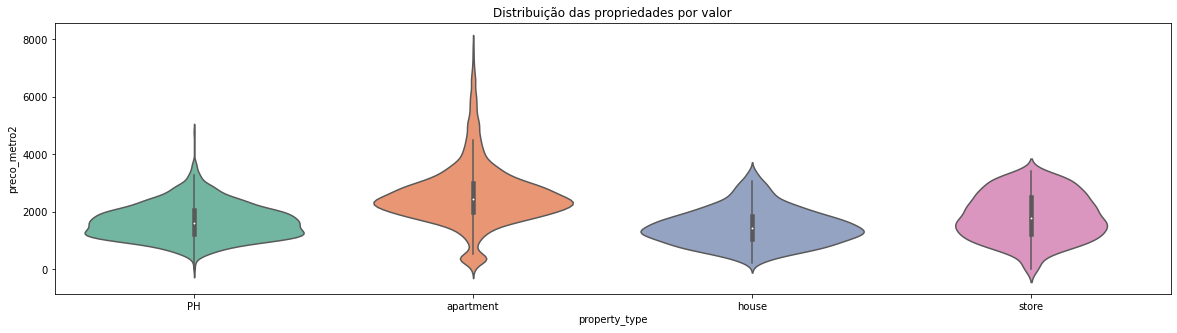

In [29]:
ax = sns.violinplot(data = prop, x = "property_type" , y = "preco_metro2", palette='Set2')
plt.title("Distribuição das propriedades por valor")
ax.figure.set_size_inches(20, 5)

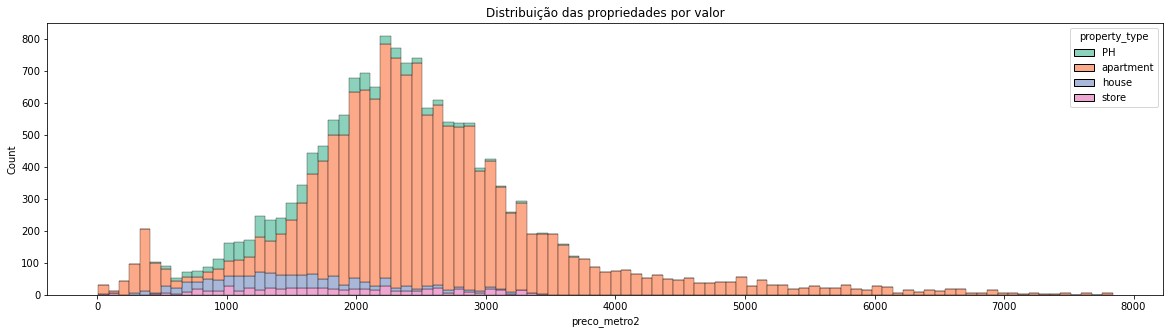

In [30]:
ay = sns.histplot(data=prop, x="preco_metro2", hue="property_type", multiple='stack', palette='Set2')
plt.title("Distribuição das propriedades por valor")
ay.figure.set_size_inches(20, 5)

## Criando variáveis

### Faixas de Preco

In [31]:
prop['Faixas_de_preco_m2'] = pd.qcut(x = prop.preco_metro2, q = 10, labels = [1,2,3,4,5,6,7,8,9,10])

In [32]:
prop.head()

,property_type,place_name,lat,lon,surface_total_in_m2,price_usd,preco_metro2,Faixas_de_preco_m2
0,PH,Mataderos,-34.661824,-58.508839,55.0,62000.0,1127.272727,1
1,apartment,Mataderos,-34.652262,-58.522982,55.0,72000.0,1309.090909,2
2,apartment,Belgrano,-34.559873,-58.443362,45.0,138000.0,3066.666667,9
3,apartment,Belgrano,-34.559873,-58.443362,65.0,195000.0,3000.000000,8
4,PH,Mataderos,-34.652356,-58.501624,140.0,239000.0,1707.142857,2


In [33]:
tb = prop.loc[prop.property_type == 'apartment', ['place_name','Faixas_de_preco_m2', 'preco_metro2']].\
pivot_table(values = 'place_name', index = 'place_name', columns = 'Faixas_de_preco_m2', aggfunc = 'count')
tb.round()

Faixas_de_preco_m2,1,2,3,4,5,6,7,8,9,10
place_name,,,,,,,,,,
Abasto,2,6,6,5,8,8,3,3,0,0
Agronomía,0,0,3,4,4,7,2,0,0,0
Almagro,45,47,111,144,110,67,43,46,24,11
Balvanera,30,95,94,53,33,34,15,12,4,1
Barracas,7,54,63,27,22,27,18,11,7,5
...,...,...,...,...,...,...,...,...,...,...
Villa Real,1,0,2,1,0,0,0,0,0,0
Villa Santa Rita,0,2,1,4,4,2,0,0,0,0
Villa Soldati,2,0,1,0,0,0,0,0,0,0


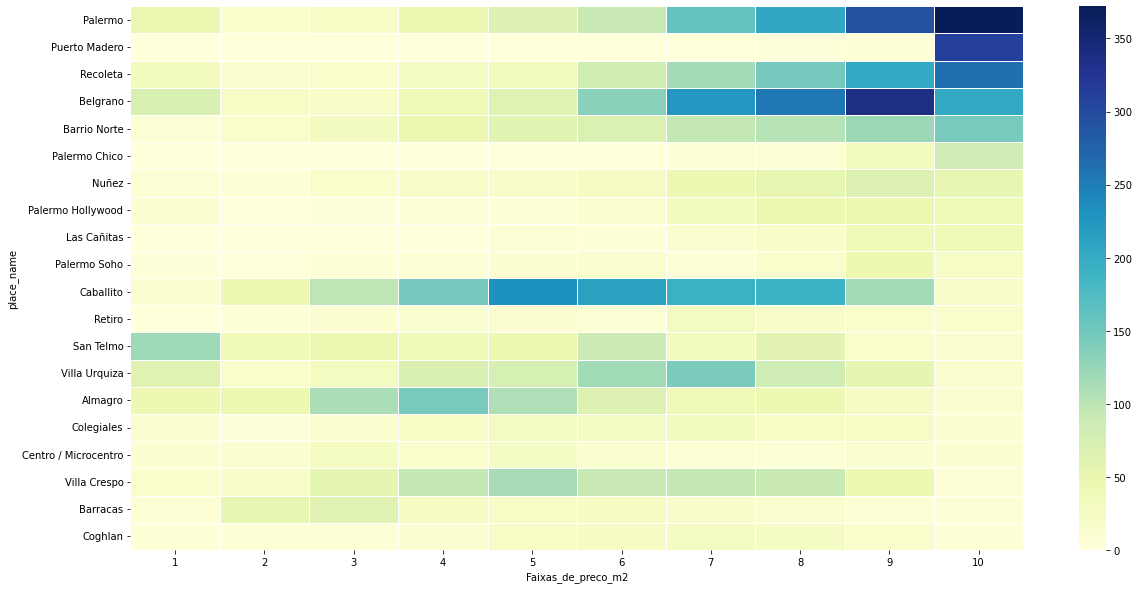

In [34]:
az = sns.heatmap( data = tb.sort_values(by = 10, ascending = False).head(20) , linewidths=1, cmap="YlGnBu")
az.figure.set_size_inches(20, 10)

---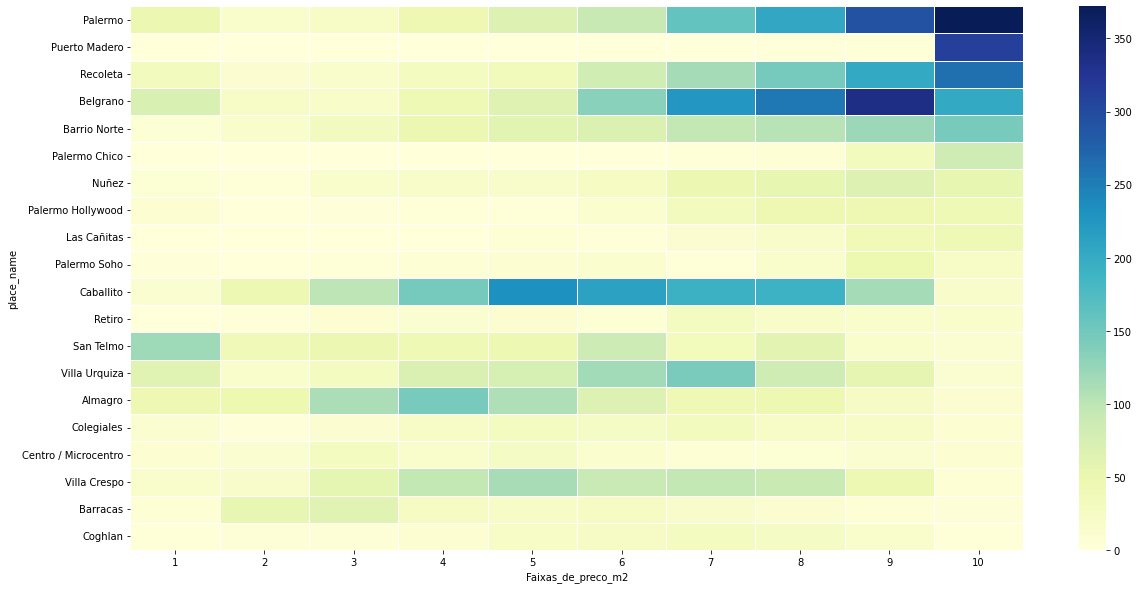